In [3]:
import csv
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from math import sqrt
import analyze
from itertools import chain

In [6]:
f = open('data/time_series_covid19_deaths_global.csv')
reader = csv.reader(f)
first = True
rows = []

num_cols = -1
def default():
  return np.zeros(shape=(num_cols,))
province_counts = defaultdict(default)
agg_counts = defaultdict(default)
region_counts = defaultdict(default)
us_counts = defaultdict(default)
for row in reader:
  if first:
    columns = row
    first = False
  else:
    rows.append(row)
    series = np.array(list(map(float, row[4:])))
    if num_cols == -1:
        num_cols = series.shape[0]
        print('Num cols: %d' % num_cols)
    if row[0] == '':
      region_counts['{} (Deaths)'.format(row[1])] = series
    else:
      province_counts[row[0]] = series
      agg_counts[row[1]] += series

Num cols: 62


In [3]:
hosps = {
    'SCC (Hosps from 3/12)' : {
        'day' : np.array([12, 13, 14, 15, 17, 18, 19, 20, 21, 22]),
        'count' : np.array([37, 38, 48, 52, 56, 62, 65, 93, 108, 116])
    },
    'SCC (Deaths from 3/12)' : {
        'day' : None,#np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]),
        'count' : np.array([1, 2, 2, 4, 5, 6, 6, 8, 8, 10, 13, 16, 17, 19, 20])
    },
    'NYS (Hosps from 3/17)' : {
        'day' : np.array([17, 18, 19, 20, 21, 22, 23, 24, 25]), 
        'count' : np.array([264, 549, 777, 1255, 1603, 1974, 2635, 3234, 3805])
    },
    'NYS (Hosps from 3/12)' : {
        'day' : np.array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]),
        'count' : np.array([47, 50, 117, 137, 158, 264, 549, 777, 1255, 1603, 1974, 2635, 3234, 3805])
    },
    'NYS (Deaths from 3/17)' : {
        'day' : np.array([17, 18, 19, 20, 21, 22, 23]), 
        'count' : np.array([13.,  16.,  34.,  42.,  60., 117., 157.])
    }    
}

In [4]:
def calculate_growth(series, days=None, thresh=10, start=5):
  if days is None:
      days = np.arange(0, series.shape[0])
  if ((series < thresh).all()):
    return None
  keep = series >= start
  series = series[keep]
  days = days[keep]
  if (days.shape[0] < 5):
    return None
  print(series)
  print(days)
  model = analyze.ExponentialGrowthRateEstimator(family='NegativeBinomial', alpha=0.10)
  model.fit(day=days, cases=series)
  print(np.diff(series))
  print(model.fitted_glm.mu)
  est = model.growth_rate()
  low, high = model.growth_rate_confint()
  return (max(low, 0), est, high)

In [5]:
growths = dict()
dataset = region_counts.items()
for k, v in dataset:
  growth = calculate_growth(v, thresh = 50, start = 5)
  if growth:
    print(' (for %s)' % k)
    growths[k] = growth

for k, v in hosps.items():
  growth = calculate_growth(v['count'], v['day'], thresh = 10, start = 5)
  if growth:
    print(' (for %s)' % k)
    growths[k] = growth

[ 5. 10. 14. 21. 37. 67. 75. 88.]
[54 55 56 57 58 59 60 61]
[0. 0. 0. 0. 0. 0. 0.]
[ 5.  4.  7. 16. 30.  8. 13.]
[ 6.005146    7.36300963  9.02790887 11.06926959 13.572216   16.64112032
 20.40395507]
 (for Belgium (Deaths))
[  6.   9.  11.  19.  19.  33.  48.  48.  79.  91.  91. 148. 148. 148.
 243. 450. 562. 674. 860.]
[43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[  3.   2.   8.   0.  14.  15.   0.  31.  12.   0.  57.   0.   0.  95.
 207. 112. 112. 186.]
[  2.52160792   3.25034041   4.18967307   5.40046833   6.96117756
   8.97292421  11.56605592  14.90859014  19.21710059  24.77074973
  31.92937661  41.15681204  53.05093168  68.38239438  88.14457565
 113.61793174 146.45296454 188.77716304]
 (for France (Deaths))
[  7.   9.  11.  17.  24.  28.  44.  67.  84.  94. 123.]
[51 52 53 54 55 56 57 58 59 60 61]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 2.  2.  6.  7.  4. 16. 23. 17. 10. 29.]
[ 2.89637578  3.73947135  4.82798057  6.23

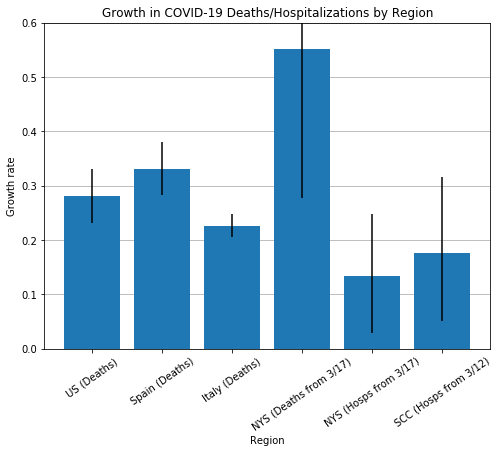

In [6]:
to_plot = {k:growths[k] for k in ['US (Deaths)', 'Spain (Deaths)', 'Italy (Deaths)', 'NYS (Deaths from 3/17)', 'NYS (Hosps from 3/17)', 'SCC (Hosps from 3/12)']}
names = list(to_plot.keys())
err_l = list([v[1]-v[0] for v in to_plot.values()])
ests  = list([v[1] for v in to_plot.values()])
err_h = list([v[2]-v[1] for v in to_plot.values()])
errs = np.array([err_l, err_h])
plt.rcParams['axes.axisbelow'] = True
plt.bar(range(len(names)), ests, yerr=errs, align='center')
plt.ylim([0,0.6])
plt.grid(axis='y')
plt.xlabel('Region')
plt.xticks(rotation=35)
plt.ylabel('Growth rate')
plt.title('Growth in COVID-19 Deaths/Hospitalizations by Region')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)


plt.xticks(range(len(names)), names)
plt.show()

In [7]:
print(to_plot)

{'US (Deaths)': (0.2317386192861457, 0.2807769465850707, 0.331767601680351), 'Spain (Deaths)': (0.2828858008657318, 0.3309685195612675, 0.38085338450831974), 'Italy (Deaths)': (0.2049444450107223, 0.2259747338443976, 0.2473720711758347), 'NYS (Deaths from 3/17)': (0.277247709862265, 0.5511017347972325, 0.8836726604508309), 'NYS (Hosps from 3/17)': (0.028959220342284153, 0.13358123210226447, 0.24884094954417102), 'SCC (Hosps from 3/12)': (0.052045456145885405, 0.17648784072987445, 0.3156500332750909)}
